In [2]:
import pandas as pd

df = pd.read_csv("spam.csv")
print(df.info)

<bound method DataFrame.info of      Category                                            Message
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...
...       ...                                                ...
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham               Will ü b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>


In [3]:
print(df.columns)

Index(['Category', 'Message'], dtype='object')


In [4]:
df.isna().sum()

Category    0
Message     0
dtype: int64

In [5]:
# Makes sure only two categories are there
df['Category'].nunique()

2

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded_category = ohe.fit_transform(df[['Category']])
encoded_category_df = pd.DataFrame(encoded_category,columns=ohe.get_feature_names_out(['Category'])) 
df = pd.concat([df.drop('Category',axis=1) , encoded_category_df],axis=1)
df

,Message,Category_spam
0,"Go until jurong point, crazy.. Available only ...",0.0
1,Ok lar... Joking wif u oni...,0.0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1.0
3,U dun say so early hor... U c already then say...,0.0
4,"Nah I don't think he goes to usf, he lives aro...",0.0
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1.0
5568,Will ü b going to esplanade fr home?,0.0
5569,"Pity, * was in mood for that. So...any other s...",0.0
5570,The guy did some bitching but I acted like i'd...,0.0


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, r2_score
from sklearn.linear_model import Lasso,Ridge,LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor


X = df['Message']
y = df['Category_spam']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size = 0.2,stratify=y)

models = {
    'Lasso':Lasso(),
    'Ridge':Ridge(),
    'LogisticRegression':LogisticRegression(),
    'RandomForestRegressor':RandomForestRegressor(),
    'GradientBoostingRegressor':GradientBoostingRegressor(),    
    'SVR':SVR(),
    'KNeighborsRegressor':KNeighborsRegressor(),
    'DecisionTreeRegressor':DecisionTreeRegressor()
}

scores = {}
for name , model in models.items():
    pipeline = Pipeline(steps=[
        ('vectorizer',TfidfVectorizer()),
        ('model',model)
    ])
    pipeline.fit(X_train,y_train)
    y_pred = pipeline.predict(X_test)
    scores[name] = r2_score(y_pred,y_test)

for name,score in scores.items():
    print(f'{name} : {score}')

Lasso : 0.0
Ridge : 0.7651047902455272
LogisticRegression : 0.7061948557537019
RandomForestRegressor : 0.7767635691569752
GradientBoostingRegressor : 0.6295860818406014
SVR : 0.6592533578098589
KNeighborsRegressor : 0.36155896983862623
DecisionTreeRegressor : 0.6427687244236677


In [20]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

models = {
    'RandomForestClassifier':RandomForestClassifier(),
    'GradientBoostingClassifier':GradientBoostingClassifier(),    
    'SVC':SVC(probability=True),
    'KNeighborsClassifier':KNeighborsClassifier(),
    'DecisionTreeClassifier':DecisionTreeClassifier()
}

scores = {}
for name , model in models.items():
    pipeline = Pipeline(steps=[
        ('vectorizer',TfidfVectorizer()),
        ('model',model)
    ])
    pipeline.fit(X_train,y_train)
    y_pred = pipeline.predict(X_test)
    scores[name] = f1_score(y_pred,y_test)

for name,score in scores.items():
    print(f'{name} : {score}')

RandomForestClassifier : 0.8712121212121212
GradientBoostingClassifier : 0.8897058823529411
SVC : 0.9247311827956989
KNeighborsClassifier : 0.8372093023255814
DecisionTreeClassifier : 0.865979381443299


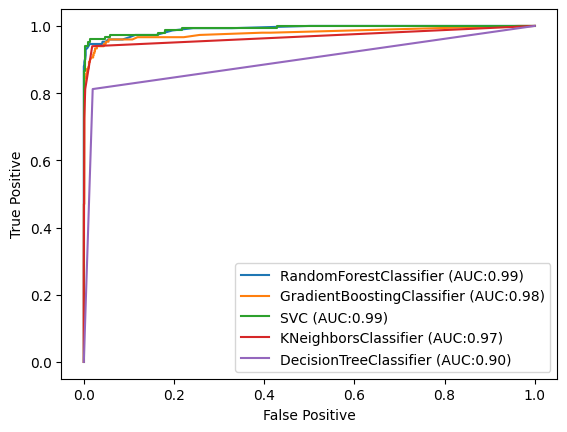

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
for name , model in models.items():
    pipeline = Pipeline(steps=[
        ('vectorizer',TfidfVectorizer()),
        ('model',model)
    ])
    pipeline.fit(X_train,y_train)
    y_probs = pipeline.predict_proba(X_test)[:,1]
    fpr,tpr,_ = roc_curve(y_test,y_probs)
    auc = roc_auc_score(y_test,y_probs)
    plt.plot(fpr,tpr,label=f"{name} (AUC:{auc:.2f})")

plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.legend(loc='lower right')
plt.show()

In [35]:
from sklearn.model_selection import GridSearchCV as GCV

param_grids = {
    'model__C':[0.1,1,10],
    'model__kernel':['rbf','linear','poly','sigmoid'],
    'model__gamma':['scale','auto']
}
pipeline = Pipeline(steps=[
    ('vectorizer',TfidfVectorizer()),
    ('model',SVC(probability=True))
])

model = GCV(pipeline,param_grids,cv=5,scoring='f1')
model.fit(X_train,y_train)

print(f"Best parameters: {model.best_params_} , f1_score: {model.best_score_}")


Best parameters: {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'linear'} , f1_score: 0.9416041683539411


In [37]:
best_model = model.best_estimator_
y_probs = best_model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test,y_probs)
print(f'AUC: {auc:.2f}')

AUC: 0.99


In [64]:
Messages = [
    "WINNER!! As a valued network customer you have been selected to receivea £900 prize reward",
    'Hi how are you? I love you.',
    'Jibrish the mf',
    'Well, what are you going to do today?',
    "Congratulations!! You have won the lottery of Rs.10000 . Please provide your bank credentials to receive. "
]
prediction = best_model.predict(Messages)
print(prediction,end='\n\n')
for idx,message in enumerate(Messages):
    print(f"'{message}' : {'Spam' if prediction[idx] else 'Not spam'}",end='\n\n')

[1. 0. 0. 0. 1.]

'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward' : Spam

'Hi how are you? I love you.' : Not spam

'Jibrish the mf' : Not spam

'Well, what are you going to do today?' : Not spam

'Congratulations!! You have won the lottery of Rs.10000 . Please provide your bank credentials to receive. ' : Spam



In [66]:
from joblib import dump
dump(best_model,'spam_detection_model.pkl')

['spam_detection_model.pkl']